In [36]:
import csv
import random

In [37]:
f= open('title_refrigerator3.csv', 'r')

In [38]:
f2 = open('labelled_jumbled2.csv', 'w', newline = '')
csvreader = csv.reader(f)
csvwriter = csv.writer(f2)
lines = list(csvreader)[1:]
# example = lines[0][1]
csvwriter.writerow(['text', 'labels'])
for line in lines:
    labels = []
    text = line[1]
    if(text == ""):
        continue
    text = text.replace('(','')
    text = text.replace(')','')
    brand = line[2]
    model = line[3]
    num_brand_words = len(brand.split())
    start_index_brand = text.find(brand)
    num_model_words = len(model.split())
    start_index_model = text.find(model)
    brand_start = 0
    model_start = 0
    for word in text.split():
        if(word == brand.split()[0]):
            labels.append('B-br')
            brand_start = 1
        elif(word == model.split()[0]):
            labels.append('B-mo')
            model_start = 1
        elif (num_brand_words > 1 and brand_start == 1):
            labels.append('I-br')
            num_brand_words -= 1
        elif (num_model_words > 1 and model_start == 1):
            labels.append('I-mo')
            num_model_words -= 1
        else:
            labels.append('O')
    csvwriter.writerow([text, ' '.join(labels)])

    temp = list(zip(text.split(), labels))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = list(res1), list(res2)
    csvwriter.writerow([' '.join(res1), ' '.join(res2)])

    temp = list(zip(text.split(), labels))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = list(res1), list(res2)
    # label_str = ' '.join(res2)
    csvwriter.writerow([' '.join(res1), ' '.join(res2)])

    index = random.randint(0, len(labels)-1)
    del res1[index]
    del res2[index]
    csvwriter.writerow([' '.join(res1), ' '.join(res2)])
    

In [39]:
import pandas as pd
df = pd.read_csv('labelled_jumbled.csv')
df.head()

,text,labels
0,Bosch 347 L Frost Free Double Door 3 Star Refr...,B-br O O O O O O O O O B-mo
1,Double Refrigerator Frost KDN43VL40I L Star Fr...,O O O B-mo O O O O B-br O O
2,Star 347 Door 3 Double Frost L Refrigerator Bo...,O O O O O O O O B-br O B-mo
3,Star 347 3 Double Frost L Refrigerator Bosch F...,O O O O O O O B-br O B-mo
4,Bosch 415 L Frost Free Double Door 3 Star Refr...,B-br O O O O O O O O O B-mo


In [40]:
# Split labels based on whitespace and turn them into a list
labels = [i.split() for i in df['labels'].values.tolist()]

# Check how many labels are there in the dataset
unique_labels = set()

for lb in labels:
  [unique_labels.add(i) for i in lb if i not in unique_labels]
 
print(unique_labels)

{'B-mo', 'B-br', 'O', 'I-mo', 'I-br'}


In [41]:
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(ids_to_labels)
print(labels_to_ids)

{0: 'B-br', 1: 'B-mo', 2: 'I-br', 3: 'I-mo', 4: 'O'}
{'B-br': 0, 'B-mo': 1, 'I-br': 2, 'I-mo': 3, 'O': 4}


In [42]:
from transformers import BertTokenizerFast

In [43]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# text_tokenized = tokenizer(example, padding = 'max_length', max_length = 100, return_tensors = 'pt')
# print(text_tokenized)

In [44]:
import torch

def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=100, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 100, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [45]:
import numpy as np

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

In [46]:
from transformers import BertForTokenClassification

class BertModel(torch.nn.Module):

    def __init__(self):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

In [47]:
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm
def train_loop(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
    # print(1)
    # a, b = next(iter(train_dataloader))
    # print(a)

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):
        # print('test')
        total_acc_train = 0
        total_loss_train = 0

        model.train()
        # print('test4')
        for train_data, train_label in tqdm(train_dataloader):
            # print('test2')
            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):
              # print('test3')                
              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()
              # print('test1')

        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

LEARNING_RATE = 5e-3
EPOCHS = 5
BATCH_SIZE = 2

model = BertModel()
train_loop(model, df_train, df_val)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

Epochs: 1 | Loss:  0.193 | Accuracy:  0.948 | Val_Loss:  0.064 | Accuracy:  0.986


100%|██████████| 813/813 [12:39<00:00,  1.07it/s]


Epochs: 2 | Loss:  0.080 | Accuracy:  0.981 | Val_Loss:  0.043 | Accuracy:  0.991


100%|██████████| 813/813 [11:40<00:00,  1.16it/s]


Epochs: 3 | Loss:  0.055 | Accuracy:  0.986 | Val_Loss:  0.029 | Accuracy:  0.993


100%|██████████| 813/813 [10:19<00:00,  1.31it/s]


Epochs: 4 | Loss:  0.041 | Accuracy:  0.989 | Val_Loss:  0.027 | Accuracy:  0.991


100%|██████████| 813/813 [10:17<00:00,  1.32it/s]


Epochs: 5 | Loss:  0.033 | Accuracy:  0.989 | Val_Loss:  0.021 | Accuracy:  0.993


In [48]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')


evaluate(model, df_test)

Test Accuracy:  0.990


Test Precision: 0.989
Test Recall: 0.989
Test F1 Score: 0.989


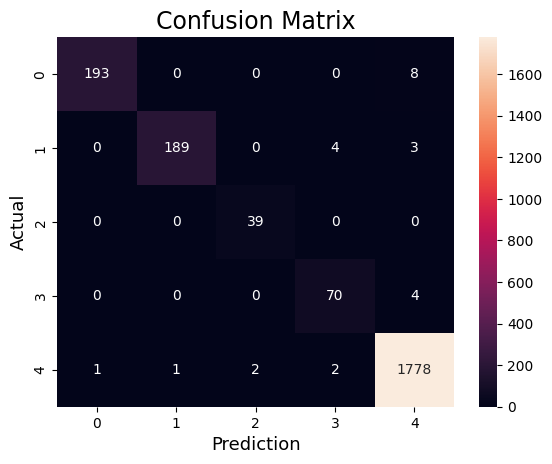

LABEL PRECISION RECALL
B-br 0.995 0.96
B-mo 0.995 0.964
I-br 0.951 1.0
I-mo 0.921 0.946
O 0.992 0.997
Accuracy   : 0.9891020052310375


In [49]:
#to calculate precision and recall
# {0: 'B-br', 1: 'B-mo', 2: 'I-br', 3: 'I-mo', 4: 'O'}
# {'B-br': 0, 'B-mo': 1, 'I-br': 2, 'I-mo': 3, 'O': 4}

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)
    test_dataloader = DataLoader(test_dataset, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    true_labels = []
    predicted_labels = []

    for test_data, test_label in test_dataloader:
        test_label = test_label.to(device)
        mask = test_data['attention_mask'].squeeze(1).to(device)
        input_id = test_data['input_ids'].squeeze(1).to(device)

        loss, logits = model(input_id, mask, test_label)

        for i in range(logits.shape[0]):
            logits_clean = logits[i][test_label[i] != -100]
            label_clean = test_label[i][test_label[i] != -100]
            predictions = logits_clean.argmax(dim=1)
            true_labels.extend(label_clean.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # print(f'Test Precision: {precision:.3f}')
    # print(f'Test Recall: {recall:.3f}')
    # print(f'Test F1 Score: {f1:.3f}')
    # count = 0;
    # for i in zip(predicted_labels, true_labels):
    #     predicted_label, true_label = i
    #     if(predicted_label == true_label):
    #         count += 1;
    # print(f'Test Accuracy: {val_accuracy:.3f}')
    for i in range(len(true_labels)):
        true_labels[i] = ids_to_labels[true_labels[i]]

    for i in range(len(predicted_labels)):
        predicted_labels[i] = ids_to_labels[predicted_labels[i]]

    
    # cm = confusion_matrix(true_labels,predicted_labels, labels=['B-br', 'B-mo', 'I-br', 'I-mo', 'O'])
    # # Plot the confusion matrix.
    # sns.heatmap(cm,
    #             annot=True,
    #             fmt='g')
    # plt.ylabel('Actual',fontsize=13)
    # plt.xlabel('Prediction',fontsize=13)
    # plt.title('Confusion Matrix',fontsize=17)
    # plt.show()
    
    
    # Finding precision and recall
    # print('LABEL', 'PRECISION', 'RECALL')
    # for i in range(cm.shape[0]):
    #     pred_equal_true = cm[i][i]
    #     predicted = 0
    #     actual = 0
    #     for j in range(cm.shape[0]):
    #         predicted += cm[j][i]
    #         actual += cm[i][j]
    #     precision = round(pred_equal_true / predicted, 3)
    #     recall = round(pred_equal_true / actual, 3)
    #     print(ids_to_labels[i], precision, recall)
    # accuracy = accuracy_score(true_labels, predicted_labels)
    # print("Accuracy   :", accuracy)


evaluate(model, df_test)


In [50]:
def align_word_ids(texts):
  
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def evaluate_one_text(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)
            
evaluate_one_text(model, 'Bosch 347 L Frost Free Double Door 3 Star Refrigerator model KDN43VL40I offers efficient cooling and ample storage space for your food and beverages.')

Bosch 347 L Frost Free Double Door 3 Star Refrigerator model KDN43VL40I offers efficient cooling and ample storage space for your food and beverages.
['B-br', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-mo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [51]:
evaluate_one_text(model, 'In the Midea MDRS619FGG28IND Frost-Free Side-by-Side Refrigerator, "frost-free" means the refrigerator does not have to be defrosted manually, as it has an auto-defrost feature.')

In the Midea MDRS619FGG28IND Frost-Free Side-by-Side Refrigerator, "frost-free" means the refrigerator does not have to be defrosted manually, as it has an auto-defrost feature.
['B-br', 'O', 'B-br', 'B-mo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-br', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-br', 'O', 'O']


In [52]:
evaluate_one_text(model, 'In the Midea MDRS619FGG28IND Frost Free Side by Side Refrigerator, the brand is listed as Midea and the model number is MDRS619FGG28IND.')

In the Midea MDRS619FGG28IND Frost Free Side by Side Refrigerator, the brand is listed as Midea and the model number is MDRS619FGG28IND.
['O', 'O', 'B-br', 'B-mo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-br', 'O', 'O', 'O', 'O', 'O', 'B-mo', 'O']


In [53]:
evaluate_one_text(model, 'Whirlpool 240 L Frost Free Multi-Door Refrigerator (FP 263D PROTTON ROY, German Steel)')

Whirlpool 240 L Frost Free Multi-Door Refrigerator (FP 263D PROTTON ROY, German Steel)
['B-br', 'O', 'O', 'O', 'O', 'O', 'O', 'B-mo', 'O', 'O', 'B-mo', 'I-mo', 'I-mo', 'I-mo', 'O', 'O', 'O', 'O']
